  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Using cached swig-4.3.0-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl.metadata (3.5 kB)
Using cached swig-4.3.0-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.9 MB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (box2d-py)
Solved in 375 episodes! Average score: 195.13


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


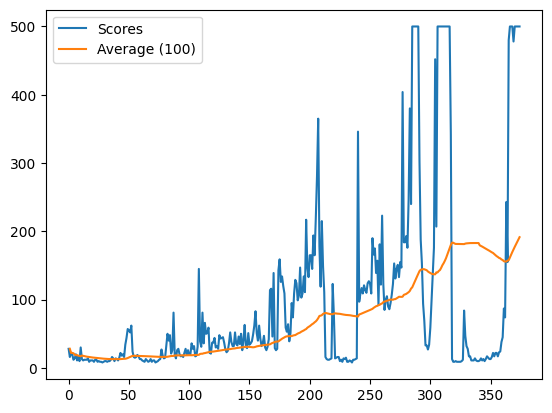

/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /tmp/cartpole-video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(



🎬 Starting video recording...
🎥 Episode 1 Score: 500.00
🎥 Episode 2 Score: 427.00
🎥 Episode 3 Score: 351.00

📊 Average Score: 426.00


In [2]:
# 1. Initialiseer de omgeving en de agent (met replay buffer en Q-netwerk).
# 2. Voor elke episode:
#    - Reset de omgeving en krijg de starttoestand.
#    - Herhaal tot de paal omvalt of de tijd op is:
#       a. Kies een actie met epsilon-greedy beleid.
#       b. Voer de actie uit en ontvang de nieuwe toestand en beloning.
#       c. Sla de ervaring op in het replay buffer.
#       d. Als genoeg data in het replay buffer:
#          - Sample een batch ervaringen.
#          - Bereken de Q-targets.
#          - Update het Q-netwerk met de loss.
#       e. Verlaag epsilon en update de huidige toestand.
#    - Bewaar de totale beloning van de episode.
# 3. Stop als de gemiddelde score boven een drempel komt.
# 4. Evalueer de agent zonder exploratie.



"""
🚀 SIMPLE CARTPOLE DQN IMPLEMENTATION 🏋️
=======================================
A simplified Deep Q-Network (DQN) implementation for solving the CartPole environment.

🎯 OBJECTIVE:a
-----------
Train an agent to balance a pole on a moving cart by:
- Applying forces to the cart (left/right)
- Learning optimal actions through experience
- Maximizing episode duration (max 500 steps)

🧠 KEY COMPONENTS:
---------------
1. DQN Network: Maps states to action values
2. Experience Replay: Stores and reuses past experiences
3. Epsilon-greedy: Balances exploration vs exploitation
"""
# 📦 Vereiste installaties voor Google Colab
!pip install gymnasium[classic_control]
!pip install torch
!pip install matplotlib
!pip install opencv-python-headless
!pip install gymnasium[box2d]

# 🛠️ IMPORT REQUIRED LIBRARIES 🛠️
import numpy as np          # Numerical operations and arrays
import random              # Random number generation for exploration
import torch               # Deep learning framework
import torch.nn as nn      # Neural network modules
import torch.optim as optim # Optimization algorithms
import gymnasium as gym    # Updated to use gymnasium instead of gym
from collections import deque # Double-ended queue for replay buffer
import matplotlib.pyplot as plt # Visualization
from IPython.display import HTML, display
from base64 import b64encode
import os
import cv2                 # For pixel graphics processing
from gymnasium.wrappers import RecordVideo  # Updated import


# 🎮 HYPERPARAMETERS 🎮
BUFFER_SIZE = 1000    # Maximum size of experience replay buffer
BATCH_SIZE = 32       # Number of experiences to learn from at once
GAMMA = 0.99         # Discount factor for future rewards
LR = 1e-3           # Learning rate for neural network
EPSILON_START = 1.0  # Initial exploration rate
EPSILON_END = 0.01   # Minimum exploration rate
EPSILON_DECAY = 0.995 # Rate at which exploration decreases


# 🧠 NEURAL NETWORK
class SimpleDQN(nn.Module):
    """
    Simple Q-Network with two fully connected layers.

    Architecture:
    - Input: State dimensions (4 for CartPole)
    - Hidden Layer: 64 neurons with ReLU activation
    - Output: Action values (2 for CartPole)
    """
    def __init__(self, state_size, action_size):
        """
        Initialize the Q-Network.
        Args:
            state_size (int): Dimension of state space
            action_size (int): Number of possible actions
        """
        super(SimpleDQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)    # First fully connected layer
        self.fc2 = nn.Linear(64, action_size)   # Output layer for action values

    def forward(self, x):
        """
        Forward pass through the network.
        Args:
            x (torch.Tensor): Input state tensor
        Returns:
            torch.Tensor: Q-values for each action
        """
        x = torch.relu(self.fc1(x))    # Apply ReLU activation
        return self.fc2(x)             # Output Q-values

# 🗃️ REPLAY BUFFER
class ReplayBuffer:
    """
    Stores and samples experiences for training.

    Features:
    - Fixed-size circular buffer using deque
    - Random sampling for decorrelated learning
    - Automatic conversion to PyTorch tensors
    """
    def __init__(self, size):
        """Initialize replay buffer with fixed size."""
        self.memory = deque(maxlen=size)
        self.max_size = size    # Track maximum size for monitoring

    def add(self, state, action, reward, next_state, done):
        """Add experience to memory."""
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """Sample random batch of experiences."""
        if len(self.memory) < batch_size:
            return None    # Prevent sampling when buffer is too small
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (torch.FloatTensor(states),
                torch.LongTensor(actions).unsqueeze(1),
                torch.FloatTensor(rewards).unsqueeze(1),
                torch.FloatTensor(next_states),
                torch.FloatTensor(dones).unsqueeze(1))

    def __len__(self):
        """Return current size of memory."""
        return len(self.memory)

    def is_ready(self, batch_size):
        """Check if enough experiences are available."""
        return len(self) >= batch_size

# 🤖 DQN AGENT
class DQNAgent:
    """
    DQN Agent that learns to play CartPole.

    Key Features:
    - Epsilon-greedy exploration
    - Experience replay learning
    - Gradual reduction in exploration
    """
    def __init__(self, state_size, action_size):
        """Initialize DQN Agent with networks and memory."""
        self.state_size = state_size
        self.action_size = action_size
        self.qnetwork = SimpleDQN(state_size, action_size)
        self.optimizer = optim.Adam(self.qnetwork.parameters(), lr=LR)
        self.memory = ReplayBuffer(BUFFER_SIZE)
        self.epsilon = EPSILON_START
        self.training_steps = 0    # Track number of training steps


    def act(self, state, eval_mode=False):
        """Select action using epsilon-greedy policy."""
        if not eval_mode and random.random() < self.epsilon:
            return random.randint(0, self.action_size - 1)

        self.qnetwork.eval()    # Set network to evaluation mode
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0)
            action_values = self.qnetwork(state)
        self.qnetwork.train()   # Set network back to training mode
        return torch.argmax(action_values).item()

    def step(self, state, action, reward, next_state, done):
        """Process one step of experience."""
        # Store experience in memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn if enough samples are available
        if self.memory.is_ready(BATCH_SIZE):
            experiences = self.memory.sample(BATCH_SIZE)
            if experiences is not None:
                self.learn(experiences)
                self.training_steps += 1

    def learn(self, experiences):
        """Update network weights using sampled experiences."""
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q-values for next states
        with torch.no_grad():
            Q_targets_next = self.qnetwork(next_states).max(1)[0].unsqueeze(1)

        # Compute Q targets for current states
        Q_targets = rewards + (GAMMA * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork(states).gather(1, actions)

        # Compute loss and perform optimization step
        loss = nn.MSELoss()(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update exploration rate
        self.epsilon = max(EPSILON_END, self.epsilon * EPSILON_DECAY)

# 🚀 TRAINING FUNCTION
def train_agent(n_episodes=2000):
    """
    Train the DQN agent on CartPole.

    Process:
    1. Reset environment for each episode
    2. Take actions and collect experiences
    3. Learn from experiences
    4. Track progress with scores

    Args:
        n_episodes (int): Maximum number of training episodes
    Returns:
        DQNAgent: Trained agent
    """
    env = gym.make("CartPole-v1")
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)
    scores = []


    for i_episode in range(1, n_episodes + 1):
        # Adjust reset for different Gym versions
        reset_result = env.reset()
        state = reset_result if isinstance(reset_result, np.ndarray) else reset_result[0]


        score = 0
        done = False
        while not done:
            action = agent.act(state)
            step_result = env.step(action)


            # Adjust step output for different Gym versions
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
            else:
                next_state, reward, done, truncated, _ = step_result
                done = done or truncated


            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward


        scores.append(score)


        if len(scores) >= 100 and np.mean(scores[-100:]) >= 195.0:
            print(f"Solved in {i_episode} episodes! Average score: {np.mean(scores[-100:])}")
            break


    # Plot training progress
    plt.plot(scores, label="Scores")
    plt.plot([np.mean(scores[max(0, i-100):i]) for i in range(len(scores))], label="Average (100)")
    plt.legend()
    plt.show()


    return agent


# 🎨 PIXEL GRAPHICS WRAPPER
class PixelGraphicsWrapper(gym.Wrapper):
    """
    Wrapper to add chunky pixel-art style graphics to CartPole environment.
    Implements retro-style visuals with bold outlines and limited color palette.
    """
    def __init__(self, env):
        super().__init__(env)
        self.env = env
        self.pixel_size = 8  # Increased for chunkier pixels
        self.bg_color = (40, 40, 60)  # Dark background
        self.cart_color = (200, 180, 140)  # Beige/tan for cart
        self.pole_color =(194, 255, 199)  # Green for pole
        self.wheel_color = (80, 200, 80)  # Green for wheels
        self.wheel_center = (255, 255, 0)  # Yellow for wheel centers
        self.outline_color = (0, 0, 0)  # Black outlines
        self.frame_count = 0

    def render(self):
        frame = self.env.render()
        if frame is None:
            return None

        h, w = frame.shape[:2]

        # Create base canvas
        canvas = np.full((h, w, 3), self.bg_color, dtype=np.uint8)

        # Get state directly from environment
        state = self.env.unwrapped.state
        if state is None:
            return canvas

        # Extract cart position and pole angle from state
        cart_pos, _, pole_angle, _ = state

        # Calculate cart position in pixels
        cart_x = int(w/2 + cart_pos * w/4)  # Scale cart position to screen width
        cart_y = int(h * 0.7)  # Place cart at 70% of screen height

        # Draw chunky cart
        cart_width = self.pixel_size * 6
        cart_height = self.pixel_size * 3

        # Cart body with outline
        cv2.rectangle(canvas,
                     (cart_x - cart_width//2 - 2, cart_y - cart_height//2 - 2),
                     (cart_x + cart_width//2 + 2, cart_y + cart_height//2 + 2),
                     self.outline_color, -1)
        cv2.rectangle(canvas,
                     (cart_x - cart_width//2, cart_y - cart_height//2),
                     (cart_x + cart_width//2, cart_y + cart_height//2),
                     self.cart_color, -1)

        # Wheels (2 pixels each side)
        for wheel_x in [cart_x - cart_width//3, cart_x + cart_width//3]:
            # Wheel outline
            cv2.rectangle(canvas,
                         (wheel_x - self.pixel_size - 1, cart_y + cart_height//2 - 1),
                         (wheel_x + self.pixel_size + 1, cart_y + cart_height//2 + self.pixel_size * 2 + 1),
                         self.outline_color, -1)
            # Wheel fill
            cv2.rectangle(canvas,
                         (wheel_x - self.pixel_size, cart_y + cart_height//2),
                         (wheel_x + self.pixel_size, cart_y + cart_height//2 + self.pixel_size * 2),
                         self.wheel_color, -1)
            # Wheel center
            cv2.rectangle(canvas,
                         (wheel_x - self.pixel_size//2, cart_y + cart_height//2 + self.pixel_size),
                         (wheel_x + self.pixel_size//2, cart_y + cart_height//2 + self.pixel_size + self.pixel_size//2),
                         self.wheel_center, -1)

        # Draw chunky pole
        pole_length = self.pixel_size * 8
        pole_end_x = int(cart_x + np.sin(pole_angle) * pole_length)
        pole_end_y = int(cart_y - np.cos(pole_angle) * pole_length)

        # Pole outline
        cv2.line(canvas,
                (cart_x - 2, cart_y - 2),
                (pole_end_x - 2, pole_end_y - 2),
                self.outline_color, self.pixel_size + 4)
        # Pole fill
        cv2.line(canvas,
                (cart_x, cart_y),
                (pole_end_x, pole_end_y),
                self.pole_color, self.pixel_size)

        # Add score display with pixel-art style
        if hasattr(self, 'current_score'):
            score_text = f'SCORE:{int(self.current_score)}'
            # Outline
            cv2.putText(canvas, score_text, (12, 32), cv2.FONT_HERSHEY_SIMPLEX, 1,
                       self.outline_color, 4, cv2.LINE_AA)
            # Fill
            cv2.putText(canvas, score_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1,
                       (0, 255, 128), 2, cv2.LINE_AA)

        self.frame_count += 1
        return canvas

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        if hasattr(self, 'current_score'):
            self.current_score += reward
        return obs, reward, terminated, truncated, info

    def reset(self, **kwargs):
        self.current_score = 0
        return self.env.reset(**kwargs)


# 🎥 RECORD AND DISPLAY VIDEO
def record_cartpole(agent, temp_dir="/tmp/cartpole-video", episodes=3):
    """
    🎥 SHOWTIME - RECORD OUR AWESOME AGENT IN ACTION! 🎬

    RECORDING PROCESS:
    ----------------
    1. 🎮 Episode Setup:
       - Create temporary directory for videos
       - Set up environment with gym's RecordVideo wrapper
       - Initialize recording

    2. 🎯 Action Selection:
       - Use trained agent (eval mode)
       - Record automatically with gym
       - Track episode scores

    3. 📽️ Video Display:
       - Convert video for Colab display
       - Show inline HTML video
       - Return performance scores

    Parameters:
    ----------
    - agent (DQNAgent): Trained CartPole agent
    - temp_dir (str): Temporary directory for video files
    - episodes (int): Number of episodes to record

    Returns:
    -------
    - tuple: (scores list, HTML video display)
    """
    # Create and wrap the environment with pixel graphics
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    env = PixelGraphicsWrapper(env)  # Custom wrapper for pixel graphics
    # Configure video recording with basic settings
    env = RecordVideo(env, temp_dir, episode_trigger=lambda x: True)
    scores = []

    print("\n🎬 Starting video recording...")
    for episode in range(episodes):
        state, _ = env.reset()
        episode_score = 0
        done = False

        while not done:
            action = agent.act(state, eval_mode=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode_score += reward
            state = next_state
            done = terminated or truncated

        scores.append(episode_score)
        print(f"🎥 Episode {episode + 1} Score: {episode_score:.2f}")

    env.close()

    # Find the latest video file
    video_path = f"{temp_dir}/rl-video-episode-{episodes-1}.mp4"

    # Create HTML video display
    def create_video_display(video_path):
        """Create HTML video element from video file with retro-style wrapper."""
        if not os.path.exists(video_path):
            print(f"⚠️ Warning: Video file not found at {video_path}")
            return None

        video_file = open(video_path, 'rb').read()
        base64_video = b64encode(video_file).decode()
        return HTML(f'''
            <div style="
                background: #28293d;
                border: 4px solid #00ff80;
                border-radius: 8px;
                padding: 20px;
                box-shadow: 0 0 20px #00ff80;
                margin: 20px auto;
                width: fit-content;
            ">
                <div style="
                    font-family: 'Courier New', monospace;
                    color: #00ff80;
                    text-align: center;
                    margin-bottom: 10px;
                    text-shadow: 0 0 10px #00ff80;
                ">
                    🎮 CARTPOLE DQN REPLAY 🤖
                </div>
                <video width="600" height="400" controls style="
                    border: 2px solid #C2FFC7;
                    border-radius: 4px;
                ">
                    <source src="data:video/mp4;base64,{base64_video}" type="video/mp4">
                </video>
            </div>
        ''')

    print(f"\n📊 Average Score: {np.mean(scores):.2f}")
    video_display = create_video_display(video_path)
    if video_display:
        display(video_display)  # Show video in Colab
    return scores, video_display  # Return both scores and video display object

# 🏃 MAIN FUNCTION
if __name__ == "__main__":
    """
    🎮 TRAIN AND DISPLAY CARTPOLE AGENT! 🚀

    EXECUTION STEPS:
    --------------
    1. 🔧 Train the agent
    2. 🎥 Record performance
    3. 📺 Display video in Colab
    """
    trained_agent = train_agent()
    scores, video_display = record_cartpole(trained_agent)
    if video_display:  # Only display if video was created successfully
        display(video_display)  # Show video in Colab